# **Strain Gage Calculations - v3**

- All the required input files should be in the same directory as this notebook
- Output files are generated in the same directory as well.

--------
### **Import Libraries**

In [15]:
# region

import pandas as pd
import numpy as np
import re
import endaq
import plotly.express as px
from openpyxl import load_workbook
import xlsxwriter
# import sys
# from PyQt5.QtWidgets import QApplication, QFileDialog
import plotly.graph_objs as go
from scipy.interpolate import interp1d
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, Dropdown, VBox, HBox, Tab, Button
from concurrent.futures import ThreadPoolExecutor

# endregion

--------
### **References** 

<u>The formulas used are based on below references</u>: 

https://community.sw.siemens.com/s/article/rosette-strain-gauges

https://www.youtube.com/watch?v=9x-3H74a8YQ

https://amesweb.info/Stress-Strain/Strain-Gauge-Rosette-Calculation-Example.aspx


In [16]:
# region
def transform_strains_to_global(epsilon_A, epsilon_B, epsilon_C, angles):
    """
    Transform strains from the rosette's local coordinate system to the global coordinate system.

    Parameters:
    - epsilon_A (float): Measured normal strain from the first strain gauge in the rosette.
    - epsilon_B (float): Measured normal strain from the second strain gauge in the rosette.
    - epsilon_C (float): Measured normal strain from the third strain gauge in the rosette.
    - angles (list of float): The angles (in degrees) of the strain gauges relative to the global x-axis.

    Returns:
    - numpy.array: The transformed strains in the global coordinate system, containing
      the normal strains epsilon_x and epsilon_y, along with the engineering shear strain gamma_xy.
    """
    theta_A, theta_B, theta_C = np.radians(angles)
    T = np.array([
        [np.cos(theta_A)**2, np.sin(theta_A)**2, 1 * np.sin(theta_A) * np.cos(theta_A)],
        [np.cos(theta_B)**2, np.sin(theta_B)**2, 1 * np.sin(theta_B) * np.cos(theta_B)],
        [np.cos(theta_C)**2, np.sin(theta_C)**2, 1 * np.sin(theta_C) * np.cos(theta_C)]
    ])
    T_inv = np.linalg.inv(T)
    local_strains = np.array([epsilon_A, epsilon_B, epsilon_C])
    global_strains = T_inv @ local_strains
    return global_strains

def calculate_principal_strains(epsilon_x, epsilon_y, gamma_xy):
    """
    Calculate the principal strains using Mohr's circle relations.

    Parameters:
    - epsilon_x (float): Normal strain in the x-direction (global coordinate system).
    - epsilon_y (float): Normal strain in the y-direction (global coordinate system).
    - gamma_xy (float): Engineering shear strain in the global coordinate system.

    Returns:
    - numpy.array: An array containing the maximum (epsilon_1) and minimum (epsilon_2)
      principal strains. These values are critical for assessing the material's behavior
      under stress and for failure analysis.

    Note:
    - The shear strain input should be in engineering terms (total angular deformation),
      as this is the standard output from strain gauges.
    """
    C = (epsilon_x + epsilon_y) / 2
    R = np.sqrt(((epsilon_x - epsilon_y) / 2)**2 + (gamma_xy / 2)**2)
    epsilon_1 = C + R  # Maximum principal strain
    epsilon_2 = C - R  # Minimum principal strain
    return np.array([epsilon_1, epsilon_2])

def calculate_principal_stresses(principal_strains, E, v):
    """
    Calculate the principal stresses from the principal strains using material properties.

    Given the principal strains, this function applies Hooke's law in two dimensions to
    compute the principal stresses. The material's Young's modulus (E) and Poisson's ratio (v)
    are used to relate the strains to the stresses. This function assumes a linear elastic
    material behavior and plane stress conditions, which is a common scenario in thin structures
    where one dimension is significantly smaller than the other two.

    Parameters:
    - principal_strains (numpy.array): An array of the principal strains [epsilon_1, epsilon_2].
    - E (float): Young's Modulus of the material in Pascals (Pa).
    - v (float): Poisson's ratio of the material, dimensionless.

    Returns:
    - numpy.array: An array containing the principal stresses [sigma_1, sigma_2] in Pascals (Pa).
      These stresses are the maximum and minimum normal stresses that occur at the principal
      strain orientations, where the shear stress is zero.

    Note:
    - The principal strains should be provided in microstrains (με) for the calculation.
    - The function returns the principal stresses in Pascals (Pa), but they are manually
      converted to other MPa (MegaPascals) at the function return (by a /1e6 division).
    - The function holds true for isotropic materials where the stress-strain relationship 
      is governed by the isotropic form of Hooke's law.
    """
    #S = np.array([
    #    [1, v, 0],
    #    [v, 1, 0],
    #    [0, 0, (1-v)/2]
    #]) * E / (1 - v**2)
    S = np.array([
        [1, v],
        [v, 1]
    ]) * E / (1 - v**2)

    principal_stresses = S @ (principal_strains /1e6)
    return principal_stresses / 1e6  # Convert Pa to MPa

def calculate_principal_strain_orientation(epsilon_x, epsilon_y, gamma_xy):
    """
    Calculate the orientation of the principal strains from the original strain measurements using Mohr's circle analysis.
    Parameters:
    - epsilon_x (float): Normal strain in the x-direction.
    - epsilon_y (float): Normal strain in the y-direction.
    - gamma_xy (float): Engineering shear strain.
    Returns:
    - theta_p (float): Angle of the principal strain in degrees.
    """
    # Calculate the angle to the maximum principal strain
    theta_p_rad = 0.5 * np.arctan2(gamma_xy, epsilon_x - epsilon_y)
    theta_p = np.degrees(theta_p_rad)

    # Adjust the angle to ensure it's within the 0-180 degree range
    if theta_p < 0:
        theta_p += 180

    return theta_p

def calculate_biaxiality_ratio(S1, S2):
    """
    Calculate the biaxiality ratio from the principal stresses.

    The biaxiality ratio is the ratio of the second principal stress to the first principal stress.
    It is a dimensionless number that indicates the relation between the principal stresses. A
    biaxiality ratio of 1 indicates equal biaxial stress state, while a value of 0 indicates a uniaxial
    stress state. Negative values indicate that the principal stresses are of opposite signs.

    Parameters:
    - S1 (float or numpy.array): First principal stress (assumed to be the larger one in absolute value).
    - S2 (float or numpy.array): Second principal stress (assumed to be the smaller one in absolute value).

    Returns:
    - float or numpy.array: The biaxiality ratio, a dimensionless quantity indicating the biaxial state of stress.

    Note:
    - The function assumes that S1 and S2 are provided such that the absolute value of S1 is
      greater than or equal to the absolute value of S2. If this is not the case, the inputs
      should be swapped.
    """
    # Ensure that sigma_1 is the larger one in absolute terms
    sigma_1 = np.where(np.abs(S1) >= np.abs(S2), S1, S2)
    sigma_2 = np.where(np.abs(S1) >= np.abs(S2), S2, S1)
    
    # Calculate the biaxiality ratio
    biaxiality_ratio = sigma_2 / sigma_1
    
    return biaxiality_ratio

def calculate_von_mises_stress(S1, S2, S3=0):
    """
    Calculate the von Mises stress from the principal stresses.
    
    Parameters:
    S1 (float): First principal stress in MPa.
    S2 (float): Second principal stress in MPa.
    S3 (float): Third principal stress in MPa, assumed to be zero for plane stress condition.
    
    Returns:
    float: The von Mises stress in MPa.
    """
    # Calculate the von Mises stress using the principal stresses
    sigma_vm = np.sqrt(((S1 - S2)**2 + (S1 - S3)**2 + (S2 - S3)**2) / 2)
    return sigma_vm

# endregion

---
## **Inputs**

### **Define Material Properties**

* **E**: Young's Modulus [Pa]

* **v**: Poisson's ratio

In [17]:
E = 200e9  
v = 0.3  

-------

### **Load Input Files**



>**"Name of any FEA data file here".csv**
* Specifies the input CSV data for FEA

    - First column should be time in seconds
    
    - Remaining columns are strains in each rosette channel, __(units are in [μmm/mm])__

    - Each rosette channel should be named as ***SG1_1, SG1_2, SG1_3, SG2_1*** etc.

    - Example format:

        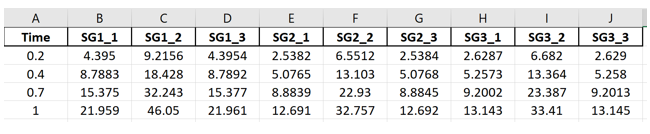
    

>**"Name of any test data file here".csv**
* Specifies the input CSV data for physical tests

    - First column should be time in seconds

    - Remaining columns are strains in each rosette channel, __(units are in [μmm/mm])__

    - Each rosette channel should be named as ***SG1_1, SG1_2, SG1_3, SG2_1*** etc.

    - Data should be exported such that it has the following format as a CSV file (see below)

    - Example format:

        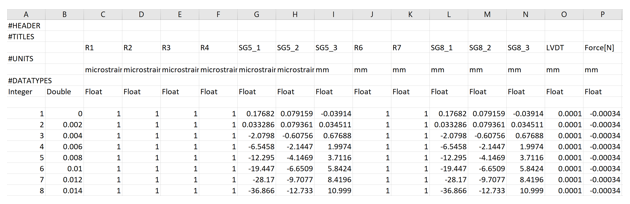


>**"Name of SG vs. rosette angle [°] file here".csv**
* Specifies the angles of each channel of a rosette with respect to their preferred axis

    - First column should be the channel name of rosette (SG1_1, SG2 etc.)

    - Remaining columns should be angles in degrees wrt to preferred axis

    - Example format:

        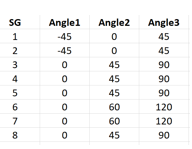

In [18]:
# Selecting the files through a dialog box
# region




# import sys
# from PyQt5.QtWidgets import QApplication, QFileDialog

# # Initialize the application
# app = QApplication(sys.argv)

# # File selection for FEA data
# file_path, _ = QFileDialog().getOpenFileName(None, 'Open FEA raw data file for SG rosettes', '', 'All Files (*);;CSV Files (*.csv)')

# # Check if a file was selected for FEA data
# if file_path:
#     print("Selected FEA data:", file_path)
# else:
#     print("No FEA data file selected.")
#     # Handle the case when no file is selected, or set file_path to a default value
#     # file_path = 'default_FEA_data.csv'


# # File selection for raw test data of strain gauge rosettes
# file_path_measured, _ = QFileDialog().getOpenFileName(None, 'Open test raw data file for SG rosettes', '', 'All Files (*);;CSV Files (*.csv)')

# # Check if a file was selected for test data
# if file_path_measured:
#     print("Selected test data:", file_path_measured)
# else:
#     print("No test data file selected.")
#     # Handle the case when no file is selected, or set file_path to a default value
#     # file_path = 'default_test_data.csv'


# # File selection for rosette angles data
# angles_file_path, _ = QFileDialog().getOpenFileName(None, 'Open File', '', 'All Files (*);;CSV Files (*.csv)')

# # Check if a file was selected for rosette angles data
# if angles_file_path:
#     print("Selected rosette angles data:", angles_file_path)
# else:
#     print("No rosette angles data file selected.")
#     # Handle the case when no file is selected, or set angles_file_path to a default value
#     # angles_file_path = 'default_angles_data.csv'



# endregion

##### **Assign rosette configurations/angles**

In [19]:
# Load the CSV file containing the rosette angles
# region
angles_file_path = 'rosette_angles_v3.csv'
rosette_angles_df = pd.read_csv(angles_file_path)
print("Selected rosette angles data:", angles_file_path)
# endregion

Selected rosette angles data: rosette_angles_v3.csv


In [20]:
rosette_angles_df

,SG,Angle1,Angle2,Angle3
0,1,-45,0,45
1,2,-45,0,45
2,3,-45,0,45
3,4,-45,0,45
4,5,-45,0,45
...,...,...,...,...
96,97,-45,0,45
97,98,-45,0,45
98,99,-45,0,45
99,100,-45,0,45


---
##### **Read SG results from FEA**

In [21]:
# Load the CSV file extracted from FEA, using "Strain Gage Toolbox" inside ANSYS Mechanical
# region

#file_path_FEA = 'SG_sample_out_data_sg_filtered_v3_long_test.csv'
file_path_FEA = 'solid1.csv'

if file_path_FEA:
    data = pd.read_csv(file_path_FEA)
    time = data['Time']
    strain_gauge_data_FEA = data.iloc[:, 1:].filter(regex='SG')
    strain_gauge_data_FEA.reset_index(drop=True, inplace=True)
    time.reset_index(drop=True, inplace=True)
else:
    print("The input file is not read. Check whether it is in the correct directory or has the correct file extension")

print("Selected test data from directory:   ", file_path_FEA)
strain_gauge_data_FEA
# endregion

Selected test data from directory:    solid1.csv


,SG1_1,SG1_2,SG1_3,SG2_1,SG2_2,SG2_3,SG3_1,SG3_2,SG3_3,SG4_1,SG4_2,SG4_3,SG5_1,SG5_2,SG5_3
0,2.5382,6.5512,2.5384,4.3950,9.2157,4.3954,2.6351,6.6891,2.6354,2.6284,6.6807,2.6288,2.9488,7.142,2.9490
1,5.0765,13.1030,5.0768,8.7884,18.4290,8.7892,5.2701,13.3780,5.2707,5.2569,13.3610,5.2576,5.8973,14.284,5.8979
2,8.8839,22.9300,8.8845,15.3750,32.2430,15.3770,9.2225,23.4120,9.2237,9.1995,23.3820,9.2007,10.3200,24.995,10.3210
3,12.6910,32.7570,12.6920,21.9590,46.0510,21.9610,13.1750,33.4450,13.1770,13.1420,33.4030,13.1440,14.7410,35.706,14.7430


---
##### **Read SG results from Test**

In [22]:
# region

#file_path_measured = 'SG_sample_out_data_raw_format.csv'
file_path_measured = 'ref.csv'

if file_path_measured:

    if "_raw_format" in file_path_measured:
        data = pd.read_csv(file_path_measured)
        data.drop([0,2,3,4,5,6], inplace=True)
        data.columns=data.iloc[0]
        new_columns = data.columns.tolist()
        new_columns[1] = 'Time'
        data.columns = new_columns
        data.drop([1], inplace=True)
        data.drop(data.columns[0], axis=1, inplace=True)
        time = data['Time']
        strain_gauge_data_measured = data.iloc[:, 1:].filter(regex='SG')
        strain_gauge_data_measured.reset_index(drop=True, inplace=True)
        time.reset_index(drop=True, inplace=True)
        strain_gauge_data_measured
        print("Selected test data from directory:   ", file_path_measured)
        
    else:
        print("""The input file is not read from raw format. Check whether it is in the correct directory or has the correct file name convention, with '_raw_data' suffix.
The program will proceed by assuming that the data is already in a clean format. """)
        
        time = data['Time']
        strain_gauge_data_measured = data.iloc[:, 1:].filter(regex='SG')
        strain_gauge_data_measured.reset_index(drop=True, inplace=True)
        time.reset_index(drop=True, inplace=True)
        strain_gauge_data_measured

# endregion

The input file is not read from raw format. Check whether it is in the correct directory or has the correct file name convention, with '_raw_data' suffix.
The program will proceed by assuming that the data is already in a clean format. 


---
### **Calculations**

* The main function for the calculation of all variables is defined here:

In [23]:
# Function Definition
# region

def calculate_all_SG_variables(strain_gauge_data, rosette_angles_df):
    new_columns = []  # List to store new columns

    # Get a list of column names that match the pattern 'SG(\d+)_'
    matching_columns = [col for col in strain_gauge_data.columns if re.search(r'SG(\d+)_', col)]
    # Extract the numerical part from the matching column names
    sg_numbers = [int(re.search(r'SG(\d+)_', col).group(1)) for col in matching_columns]
    # Remove duplicates and sort the extracted numerical values
    sg_numbers = sorted(set(sg_numbers))

    for sg_number in sg_numbers:
        sg_cols = [col for col in strain_gauge_data.columns if f'SG{sg_number}_' in col]

        # Ensure there are three columns per strain gauge
        if len(sg_cols) == 3:
            rosette_row = rosette_angles_df[rosette_angles_df['SG'] == sg_number]
            if not rosette_row.empty:
                current_angles = rosette_row.iloc[0, 1:].values
                strains = strain_gauge_data[sg_cols].values.astype(dtype=np.float64)
                global_strains = np.array([transform_strains_to_global(*strain, current_angles) for strain in strains])
                principal_strains = np.array([calculate_principal_strains(strain[0], strain[1], strain[2]) for strain in global_strains])
                principal_stresses = np.array([calculate_principal_stresses(strain, E, v) for strain in principal_strains])
                principal_strain_orientation = np.array([calculate_principal_strain_orientation(strain[0], strain[1], strain[2]) for strain in global_strains])
                biaxiality_ratios = calculate_biaxiality_ratio(principal_stresses[:, 0], principal_stresses[:, 1])
                von_mises_stresses = np.array([calculate_von_mises_stress(*stress) for stress in principal_stresses])

                # Store new columns in separate DataFrames
                for i, strain_type in enumerate(['epsilon_x [με]', 'epsilon_y [με]', 'gamma_xy [με]']):
                    new_columns.append(pd.DataFrame({f'SG{sg_number}_{strain_type}': global_strains[:, i]}))
                new_columns.append(pd.DataFrame({f'SG{sg_number}_sigma_1 [MPa]': principal_stresses[:, 0],
                                                 f'SG{sg_number}_sigma_2 [MPa]': principal_stresses[:, 1],
                                                 f'SG{sg_number}_theta_p [°]': principal_strain_orientation,
                                                 f'SG{sg_number}_Biaxiality_Ratio': biaxiality_ratios,
                                                 f'SG{sg_number}_von_Mises [MPa]': von_mises_stresses}))
            else:
                print(f'Angles for Rosette {sg_number} not found in angles file.')
        else:
            print(f'Unexpected number of columns for Rosette {sg_number}.')

    # Concatenate all new columns to the original DataFrame
    strain_gauge_data = pd.concat([strain_gauge_data] + new_columns, axis=1)

    return strain_gauge_data
# endregion

In [24]:
# DEBUG sil

# Create the column names
column_names = ['Time'] + [f'SG{i}_{j}' for i in range(1, 34) for j in range(1, 4)]

# Ensure we have exactly 100 columns (including 'Time')
column_names = column_names[:100]

# Create the DataFrame
strain_gauge_data_FEA = pd.DataFrame(columns=column_names)
strain_gauge_data_measured = pd.DataFrame(columns=column_names)

# Populate 'Time' column
strain_gauge_data_FEA['Time'] = np.linspace(0, 10, 5000)
strain_gauge_data_measured['Time'] = np.linspace(0, 10, 5000)

# Populate other columns with random values between -1 and 1
for col in column_names[1:]:
    strain_gauge_data_FEA[col] = np.random.uniform(-1, 1, size=5000)
    strain_gauge_data_measured[col] = np.random.uniform(-1, 1, size=5000)


#### **1)** Output: FEA

In [25]:
# region
if file_path_FEA:
    strain_gauge_data_FEA = calculate_all_SG_variables(strain_gauge_data_FEA, rosette_angles_df)
    #strain_gauge_data_FEA.insert(0, 'Time', time)
    strain_gauge_data_FEA
# endregion


#### **2)** Output: Test

In [26]:
# region
if file_path_measured:
    strain_gauge_data_measured= calculate_all_SG_variables(strain_gauge_data_measured, rosette_angles_df)
    #strain_gauge_data_measured.insert(0, 'Time', time)
    strain_gauge_data_measured
# endregion

---
## **Results**

---
### **Plots**

In [27]:
# Create a plot button widget
# region

display_plot_button = widgets.Button(description="Display Plot")

# Function to handle button click
def on_display_plot_button_clicked(b):
    # Clear previous output
    clear_output(wait=True)
    
    # Create a sample plotly figure
    fig = go.Figure(data=go.Bar(y=[2, 3, 1]))
    
    # Display the figure
    fig.show()

# Link the button to the event handler function
display_plot_button.on_click(on_display_plot_button_clicked)

# endregion

#### Comparison: Test vs FEA

In [28]:
# Creating filters, figure properties and Test vs. FEA plots
# region
# Assuming df is your DataFrame with the columns as mentioned
if file_path_FEA:
    df =strain_gauge_data_FEA
else:
    df =strain_gauge_data_measured


# Extract sensor names, data types and channel names from calculated dataframe
# region


# Function to extract sensor names, data types, and channel names
def extract_SG_names_channels_names_and_data_types(sensor_data):
    list_SG_sensor_names = set()
    list_SG_channel_names = []
    unique_data_types = {}

    for item in sensor_data:
        parts = item.split("_")
        sensor_name = parts[0]
        
        if sensor_name.startswith("SG"):
            list_SG_sensor_names.add(sensor_name)

            if len(parts) > 1:
                if parts[1].isdigit():
                    list_SG_channel_names.append(item)
                else:
                    data_type = "_".join(parts[1:])
                    unique_data_types[data_type] = None 
    
    # Convert the list_SG_sensor_names into a list
    list_SG_sensor_names=list(list_SG_sensor_names)

    # Function to extract numbers from strings and perform natural sorting
    def natural_sort_key(s):
        return [int(text) if text.isdigit() else text.lower() for text in re.split('(\d+)', s)]



    # Sort the elements of list_SG_sensor_names again since it was messed up by set()
    list_SG_sensor_names = sorted(list_SG_sensor_names, key=natural_sort_key)
    # Convert dictionary of data types into a list
    list_SG_data_types = list(unique_data_types.keys())
    # Inject Raw Data type as a selection in the data types dropdown menu
    list_SG_data_types.insert(0, 'Raw Data [με]')

    return list_SG_sensor_names, list_SG_data_types, list_SG_channel_names

# Extract lists
list_SG_sensor_names, list_SG_data_types, list_SG_channel_names = extract_SG_names_channels_names_and_data_types(df.columns)

#list_SG_sensor_names, list_SG_data_types, list_SG_channel_names

# endregion

def create_dimension_sliders(fig, initial_height=300, min_height=100, max_height=500, height_step=10,
                             initial_width=800, min_width=300, max_width=1500, width_step=10):
    """
    Create and display sliders to control the dimensions (height and width) of a Plotly figure.

    Parameters:
    - fig: The figure object to which the dimension sliders will be linked.
    - initial_height: The initial height of the figure.
    - min_height: The minimum height of the figure.
    - max_height: The maximum height of the figure.
    - height_step: The step size for the height adjustment.
    - initial_width: The initial width of the figure.
    - min_width: The minimum width of the figure.
    - max_width: The maximum width of the figure.
    - width_step: The step size for the width adjustment.
    """
    # Function to update the height of the plot
    def update_height(height):
        fig.layout.height = height

    # Function to update the width of the plot
    def update_width(width):
        fig.layout.width = width

    # Function to handle height change
    def on_height_change(change):
        update_height(change.new)

    # Function to handle width change
    def on_width_change(change):
        update_width(change.new)

    # Create a slider widget for total_height
    height_slider = widgets.IntSlider(
        value=initial_height, 
        min=min_height, 
        max=max_height, 
        step=height_step, 
        description='Figure Height'
    )
    
    # Create a slider widget for total_width
    width_slider = widgets.IntSlider(
        value=initial_width, 
        min=min_width, 
        max=max_width, 
        step=width_step, 
        description='Figure Width'
    )
    
    # Bring sliders together
    hbox_figure_size = widgets.HBox([height_slider,width_slider])
    hbox_layout = widgets.Layout(
        display = 'flex',
        flex_flow = 'column',
        #align_items = 'center',
        width = '100%',
        margin = 'auto'
    )
    hbox_figure_size.layout = hbox_layout

    # Add an observer to the slider to update the plot height and width
    height_slider.observe(on_height_change, names='value')
    width_slider.observe(on_width_change, names='value')

    return height_slider, width_slider

# Dropdown widgets for selecting columns
dropdown_sensor = Dropdown(options=list_SG_sensor_names)
dropdown_channel = Dropdown(options=list_SG_channel_names)
dropdown_data_type = Dropdown(options=list_SG_data_types)

# Initialize the plot as a FigureWidget with subplots
fig = go.FigureWidget(
    data=[
        go.Scatter(mode='lines', name='FEA', xaxis='x1', yaxis='y1'),
        go.Scatter(mode='lines', name='Test', xaxis='x1', yaxis='y1'),
        go.Scatter(mode='lines', name='Error (%)', xaxis='x2', yaxis='y2'),
        go.Scatter(mode='lines', name='Δy', xaxis='x3', yaxis='y3')
    ],
    layout=go.Layout(
        height=300,
        xaxis=dict(domain=[0, 1], anchor='y1'),
        yaxis=dict(domain=[0.68, 1], title='y'),
        xaxis2=dict(domain=[0, 1], anchor='y2', matches='x1'),
        yaxis2=dict(domain=[0.36, 0.64], title='Error(%)'),
        xaxis3=dict(domain=[0, 1], anchor='y3', matches='x1'),
        yaxis3=dict(domain=[0, 0.32], title='Δy'),
        showlegend=True,
        margin=dict(l=5, r=5, t=6, b=5),
        font=dict(size=9)
    )
)

# Plotting function
def update_plot(sensor, channel, data_type):
    # Interpolating and calculating the data

    if dropdown_data_type.value == 'Raw Data [με]':

        y1 = strain_gauge_data_FEA[dropdown_channel.value]
        y2 = strain_gauge_data_measured[dropdown_channel.value]
    else:
        y1 = strain_gauge_data_FEA[dropdown_sensor.value + '_' + data_type]
        y2 = strain_gauge_data_measured[dropdown_sensor.value + '_' + data_type]

    x1 = np.linspace(0, len(y1)-1, len(y1))
    x2 = np.linspace(0, len(y2)-1, len(y2))

    interp_func1 = interp1d(x1, y1, kind='linear', fill_value='FEA')
    interp_func2 = interp1d(x2, y2, kind='linear', fill_value='Test')

    common_x = np.linspace(0, max(len(y1), len(y2))-1, max(len(y1), len(y2)))

    interpolated_y1 = interp_func1(common_x)
    interpolated_y2 = interp_func2(common_x)

    relative_error_percent = ((interpolated_y2 - interpolated_y1) / interpolated_y1) * 100
    difference = interpolated_y1 - interpolated_y2

    # Update the plot
    with fig.batch_update():
        fig.data[0].y = interpolated_y1
        fig.data[1].y = interpolated_y2
        fig.data[2].y = relative_error_percent
        fig.data[3].y = difference

height_slider, width_slider = create_dimension_sliders(fig)


# Function to update channel dropdown based on sensor selection
def update_channel_dropdown(*args):
    # Filter channels based on the selected sensor
    filtered_channels = [channel for channel in list_SG_channel_names if channel.startswith(dropdown_sensor.value)]
    dropdown_channel.options = filtered_channels

    # Automatically select the first filtered channel if available
    if filtered_channels:
        dropdown_channel.value = filtered_channels[0]
    else:
        dropdown_channel.value = None

# Observe changes in the sensor dropdown to update channel options
dropdown_sensor.observe(update_channel_dropdown, names='value')

# Initial call to populate the channel dropdown correctly
update_channel_dropdown()

# Link widgets to the plotting function
def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        update_plot(dropdown_sensor.value, dropdown_channel.value, dropdown_data_type.value)

dropdown_sensor.observe(on_change)
dropdown_channel.observe(on_change)
dropdown_data_type.observe(on_change)

# Initial plot update
update_plot(dropdown_sensor.value, dropdown_channel.value, dropdown_data_type.value)

# Create Tabs for organizing widgets
tab = Tab()

# Create previous/next buttons for each hbox of dropdowns
# region
button_previous_dropdown_sensor = widgets.Button(description="Previous", button_style='')
button_previous_dropdown_sensor.layout.width = '6em'
button_next_dropdown_sensor = widgets.Button(description="Next", button_style='')
button_next_dropdown_sensor.layout.width = '6em'

button_previous_dropdown_channel = widgets.Button(description="Previous", button_style='')
button_previous_dropdown_channel.layout.width = '6em'
button_next_dropdown_channel = widgets.Button(description="Next", button_style='')
button_next_dropdown_channel.layout.width = '6em'

button_previous_dropdown_data_type = widgets.Button(description="Previous", button_style='')
button_previous_dropdown_data_type.layout.width = '6em'
button_next_dropdown_data_type = widgets.Button(description="Next", button_style='')
button_next_dropdown_data_type.layout.width = '6em'

# Define the functions for handling Previous/Next button clicks for the Sensor dropdown
# region
def previous_sensor(*args):
    current_index = list_SG_sensor_names.index(dropdown_sensor.value)
    if current_index > 0:
        dropdown_sensor.value = list_SG_sensor_names[current_index - 1]

def next_sensor(*args):
    current_index = list_SG_sensor_names.index(dropdown_sensor.value)
    if current_index < len(list_SG_sensor_names) - 1:
        dropdown_sensor.value = list_SG_sensor_names[current_index + 1]

# Attach these functions to the respective buttons
button_previous_dropdown_sensor.on_click(previous_sensor)
button_next_dropdown_sensor.on_click(next_sensor)
# endregion

# Define the functions for handling Previous/Next button clicks for the Channel dropdown
# region
def previous_channel(*args):
    current_index = list_SG_channel_names.index(dropdown_channel.value)
    if current_index > 0:
        dropdown_channel.value = list_SG_channel_names[current_index - 1]

def next_channel(*args):
    current_index = list_SG_channel_names.index(dropdown_channel.value)
    if current_index < len(list_SG_channel_names) - 1:
        dropdown_channel.value = list_SG_channel_names[current_index + 1]

# Attach these functions to the respective buttons
button_previous_dropdown_channel.on_click(previous_channel)
button_next_dropdown_channel.on_click(next_channel)
# endregion

# Define the functions for handling Previous/Next button clicks for the Data Type dropdown
# region
def previous_data_type(*args):
    current_index = list_SG_data_types.index(dropdown_data_type.value)
    if current_index > 0:
        dropdown_data_type.value = list_SG_data_types[current_index - 1]

def next_data_type(*args):
    current_index = list_SG_data_types.index(dropdown_data_type.value)
    if current_index < len(list_SG_data_types) - 1:
        dropdown_data_type.value = list_SG_data_types[current_index + 1]
# endregion

# Attach these functions to the respective buttons
button_previous_dropdown_data_type.on_click(previous_data_type)
button_next_dropdown_data_type.on_click(next_data_type)


# Add show labels on/off toggle
# region
# Initial state
show_labels = True

# Function to toggle xaxis labels
def toggle_xaxis_labels(show_labels):
    fig.layout.xaxis.showticklabels = show_labels
    fig.layout.xaxis2.showticklabels = show_labels

# Create a custom toggle button widget
toggle_button = widgets.ToggleButton(
    value=show_labels,
    description='Show X-axis Labels',
    button_style='info',  # You can choose other button styles like 'success', 'danger', etc.
    layout=widgets.Layout(width='auto')
)
# Function to update the toggle button's appearance and action
def update_toggle_button(change):
    global show_labels
    show_labels = change['new']
    if show_labels:
        toggle_button.description = 'Show X-axis Labels'
        toggle_button.button_style = 'info'
    else:
        toggle_button.description = 'Hide X-axis Labels'
        toggle_button.button_style = 'danger'
    toggle_xaxis_labels(show_labels)

# Attach the update_toggle_button function to the toggle button's value change event
toggle_button.observe(update_toggle_button, names='value')
# endregion

# Create HBoxes for each dropdown menu
# region
hbox_dropdown_sensor = HBox([dropdown_sensor, button_previous_dropdown_sensor, button_next_dropdown_sensor])
hbox_dropdown_channel = HBox([dropdown_channel, button_previous_dropdown_channel, button_next_dropdown_channel])
hbox_dropdown_data_type = HBox([dropdown_data_type, button_previous_dropdown_data_type, button_next_dropdown_data_type])
# endregion

# Group dropdown menus and figure property widgets
dropdowns_container = VBox([hbox_dropdown_sensor, hbox_dropdown_channel, hbox_dropdown_data_type])
figure_properties_container = VBox([height_slider, width_slider, toggle_button])

# Assign children to the tab
tab.children = [dropdowns_container, figure_properties_container]

# Set titles for the tabs
tab.set_title(0, 'Filter Data')
tab.layout.width = '50%'

tab.set_title(1, 'Properties')

# Display the tab widget
display(tab)

# Display the plot
display(fig)
# endregion

# endregion

FigureWidget({
    'data': [{'mode': 'lines',
              'name': 'FEA',
              'type': 'scatter',
              'uid': '083c2494-d7a2-4961-82f1-5ac0d6c874da',
              'xaxis': 'x',
              'y': array([ 0.51724718,  0.63850278, -0.08467225, ...,  0.45521302, -0.59644588,
                          -0.8908787 ]),
              'yaxis': 'y'},
             {'mode': 'lines',
              'name': 'Test',
              'type': 'scatter',
              'uid': '6cca5271-14b1-4fc4-9b06-df1d046df23a',
              'xaxis': 'x',
              'y': array([ 0.12427264, -0.9746068 , -0.15449354, ...,  0.10507787, -0.52152203,
                           0.666097  ]),
              'yaxis': 'y'},
             {'mode': 'lines',
              'name': 'Error (%)',
              'type': 'scatter',
              'uid': '9a2f806d-a6bb-4aa2-b00a-f02d85d37f7e',
              'xaxis': 'x2',
              'y': array([ -75.97422644, -252.63939856,   82.46065829, ...,  -76.91677077,
        

---
#### Full Data

In [29]:
# FEA Data
# region

def create_dimension_sliders(fig, initial_height=200, min_height=100, max_height=500, height_step=10,
                             initial_width=800, min_width=300, max_width=1500, width_step=10):
    """
    Create and display sliders to control the dimensions (height and width) of a Plotly figure.

    Parameters:
    - fig: The figure object to which the dimension sliders will be linked.
    - initial_height: The initial height of the figure.
    - min_height: The minimum height of the figure.
    - max_height: The maximum height of the figure.
    - height_step: The step size for the height adjustment.
    - initial_width: The initial width of the figure.
    - min_width: The minimum width of the figure.
    - max_width: The maximum width of the figure.
    - width_step: The step size for the width adjustment.
    """
    # Function to update the height of the plot
    def update_height(height):
        fig.layout.height = height

    # Function to update the width of the plot
    def update_width(width):
        fig.layout.width = width

    # Function to handle height change
    def on_height_change(change):
        update_height(change.new)

    # Function to handle width change
    def on_width_change(change):
        update_width(change.new)

    # Create a slider widget for total_height
    height_slider = widgets.IntSlider(
        value=initial_height, 
        min=min_height, 
        max=max_height, 
        step=height_step, 
        description='Figure Height'
    )
    
    # Create a slider widget for total_width
    width_slider = widgets.IntSlider(
        value=initial_width, 
        min=min_width, 
        max=max_width, 
        step=width_step, 
        description='Figure Width'
    )
    
    # Bring sliders together
    hbox_figure_size = widgets.HBox([height_slider,width_slider])
    hbox_layout = widgets.Layout(
        display = 'flex',
        flex_flow = 'column',
        align_items = 'center',
        width = '100%',
        margin = 'auto'
    )
    hbox_figure_size.layout = hbox_layout

    # Display the sliders and the plot
    display(hbox_figure_size)

    # Add an observer to the slider to update the plot height and width
    height_slider.observe(on_height_change, names='value')
    width_slider.observe(on_width_change, names='value')

center_layout = widgets.Layout(display='flex',
                               justify_content='center',
                               align_items='center',
                               width='100%')

# Create plots based on the data available
if file_path_FEA:
    strain_gauge_data_FEA.set_index('Time', inplace=True)
    fig_full_FEA = go.FigureWidget(data=px.line(strain_gauge_data_FEA))
    fig_full_FEA.update_layout(margin=dict(l=5, r=5, t=10, b=5), font=dict(size=9), height=200)
    create_dimension_sliders(fig_full_FEA)
    display(fig_full_FEA)

# endregion

FigureWidget({
    'data': [{'hovertemplate': 'variable=SG1_1<br>Time=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'SG1_1',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': 'SG1_1',
              'showlegend': True,
              'type': 'scattergl',
              'uid': '6b968bf1-51d7-4140-816f-2f88bfbeeb82',
              'x': array([0.00000000e+00, 2.00040008e-03, 4.00080016e-03, ..., 9.99599920e+00,
                          9.99799960e+00, 1.00000000e+01]),
              'xaxis': 'x',
              'y': array([ 0.51724718,  0.63850278, -0.08467225, ...,  0.45521302, -0.59644588,
                          -0.8908787 ]),
              'yaxis': 'y'},
             {'hovertemplate': 'variable=SG1_2<br>Time=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'SG1_2',
              'line': {'color': '#EF553B', 'dash': 'solid'},
              'mar

In [30]:
# Test Data
# region
if file_path_measured:
    strain_gauge_data_measured.set_index('Time', inplace=True)
    fig_full_measured = go.FigureWidget(data=px.line(strain_gauge_data_measured))
    fig_full_measured.update_layout(margin=dict(l=5, r=5, t=10, b=5), font=dict(size=9), height=200)
    create_dimension_sliders(fig_full_measured)
    display(fig_full_measured)

# endregion

FigureWidget({
    'data': [{'hovertemplate': 'variable=SG1_1<br>Time=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'SG1_1',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': 'SG1_1',
              'showlegend': True,
              'type': 'scattergl',
              'uid': 'ebb613bf-c17a-49ce-9009-d525b859238c',
              'x': array([0.00000000e+00, 2.00040008e-03, 4.00080016e-03, ..., 9.99599920e+00,
                          9.99799960e+00, 1.00000000e+01]),
              'xaxis': 'x',
              'y': array([ 0.12427264, -0.9746068 , -0.15449354, ...,  0.10507787, -0.52152203,
                           0.666097  ]),
              'yaxis': 'y'},
             {'hovertemplate': 'variable=SG1_2<br>Time=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'SG1_2',
              'line': {'color': '#EF553B', 'dash': 'solid'},
              'mar

----
### **Excel Output**

In [31]:
# Function for generating an excel file from strain gauge output dataframe, where only von_Mises results are shown but the rest of all other data is hidden:
# region

def create_excel_from_strain_gauge_data(strain_gauge_data, input_file_path):
    excel_file_path = str(input_file_path) + "_results.xlsx"
    strain_gauge_data.to_excel(excel_file_path, index=False)
    
    wb = load_workbook(excel_file_path)
    ws = wb.active
    
    # Determine the columns to hide directly from the DataFrame
    columns_to_hide = [col for col in strain_gauge_data.columns if 'von_Mises' not in col and col != 'Time']
    for col in ws.iter_cols():
        if col[0].value in columns_to_hide:
            ws.column_dimensions[col[0].column_letter].hidden = True
    
    wb.save(excel_file_path)

with ThreadPoolExecutor() as executor:
    executor.submit(create_excel_from_strain_gauge_data, strain_gauge_data_FEA, file_path_FEA)
    executor.submit(create_excel_from_strain_gauge_data, strain_gauge_data_measured, file_path_measured)

def create_csv_from_strain_gauge_data(strain_gauge_data, input_file_path):
    csv_file_path = str(input_file_path) + "_results_von_Mises.csv"
    
    # Since CSVs don't support hidden columns, you might choose to drop the columns instead
    columns_to_retain = ['Time', 'von_Mises']  # Add any other columns you want to retain
    strain_gauge_data = strain_gauge_data[columns_to_retain]

    strain_gauge_data.to_csv(csv_file_path, index=False)

# Usage with ThreadPoolExecutor
with ThreadPoolExecutor() as executor:
    executor.submit(create_csv_from_strain_gauge_data, strain_gauge_data_FEA, file_path_FEA)
    executor.submit(create_csv_from_strain_gauge_data, strain_gauge_data_measured, file_path_measured)

# endregion